### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import skimage.transform
#import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from model import *
import cv2

In [4]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 1.14.0


In [5]:
K.set_image_data_format('channels_first')

In [6]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [7]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\Rosana\Documents\Mestrado\dissertacao\codigo_unet\scripts\model.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [8]:
# Loading full images of desired resolution:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

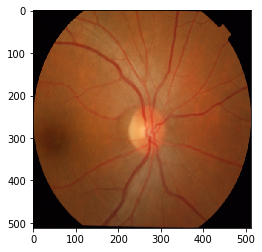

(50, 512, 512, 3)


In [9]:
plt.imshow(img_train[45])
plt.show()
print(img_train.shape)

In [10]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [11]:
red_channel_train = []
for i in (img_train):
    red = np.zeros(i.shape)
    red[:,:,0] = i[:,:,0]
    red_channel_train.append(red)

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

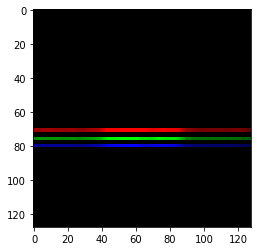

In [13]:
gen = data_generator(red_channel_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

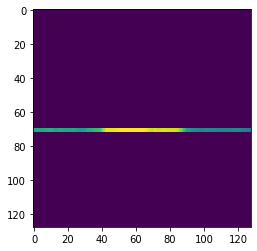

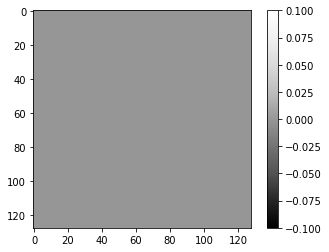

In [14]:
plt.imshow(batch[0][0][0])
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [15]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))

In [173]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [175]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

In [176]:
red_channel_test = []
for i in (img_test):
    red = np.zeros(i.shape)
    red[:,:,0] = i[:,:,0]
    red_channel_test.append(red)

In [24]:
X_valid, Y_valid = next(data_generator(red_channel_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [25]:
history = model.fit_generator(data_generator(red_channel_train, cup_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                              
                              validation_data=(X_valid, Y_valid),
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_red.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_red.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/500
99/99 [==============================] - 54s 546ms/step - loss: 1.8707 - mean_IOU_gpu: 0.0595 - dice_metric: 0.1106 - val_loss: 1.8821 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 2/500
99/99 [==============================] - 52s 526ms/step - loss: 1.8811 - mean_IOU_gpu: 0.0056 - dice_metric: 0.0110 - val_loss: 1.8043 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 3/500
99/99 [==============================] - 58s 587ms/step - loss: 1.7600 - mean_IOU_gpu: 1.6043e-04 - dice_metric: 3.2031e-04 - val_loss: 1.7078 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 4/500
99/99 [==============================] - 54s 541ms/step - loss: 1.7273 - mean_IOU_gpu: 1.2849e-04 - dice_metric: 2.5656e-04 - val_loss: 1.5741 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 5/500
99/99 [==============================] - 55s 551ms/step - loss: 1.4963 - mean_IOU_gpu: 0.0309 - dice_metric: 0.0572 - val_loss: 1.3059 - val

Epoch 82/500
99/99 [==============================] - 41s 413ms/step - loss: 0.1884 - mean_IOU_gpu: 0.6719 - dice_metric: 0.7965 - val_loss: 0.1483 - val_mean_IOU_gpu: 0.7175 - val_dice_metric: 0.8306
Epoch 83/500
99/99 [==============================] - 40s 402ms/step - loss: 0.1758 - mean_IOU_gpu: 0.7020 - dice_metric: 0.8136 - val_loss: 0.1828 - val_mean_IOU_gpu: 0.6633 - val_dice_metric: 0.7947
Epoch 84/500
99/99 [==============================] - 37s 378ms/step - loss: 0.1966 - mean_IOU_gpu: 0.6708 - dice_metric: 0.7941 - val_loss: 0.1751 - val_mean_IOU_gpu: 0.6710 - val_dice_metric: 0.8009
Epoch 85/500
99/99 [==============================] - 37s 376ms/step - loss: 0.1808 - mean_IOU_gpu: 0.6795 - dice_metric: 0.8020 - val_loss: 0.1347 - val_mean_IOU_gpu: 0.7412 - val_dice_metric: 0.8464
Epoch 86/500
99/99 [==============================] - 37s 372ms/step - loss: 0.1689 - mean_IOU_gpu: 0.7006 - dice_metric: 0.8158 - val_loss: 0.1417 - val_mean_IOU_gpu: 0.7310 - val_dice_metric: 0.

Epoch 123/500
99/99 [==============================] - 38s 386ms/step - loss: 0.1503 - mean_IOU_gpu: 0.7192 - dice_metric: 0.8304 - val_loss: 0.1360 - val_mean_IOU_gpu: 0.7378 - val_dice_metric: 0.8445
Epoch 124/500
99/99 [==============================] - 36s 368ms/step - loss: 0.1576 - mean_IOU_gpu: 0.7070 - dice_metric: 0.8230 - val_loss: 0.1296 - val_mean_IOU_gpu: 0.7445 - val_dice_metric: 0.8498
Epoch 125/500
99/99 [==============================] - 37s 370ms/step - loss: 0.1375 - mean_IOU_gpu: 0.7334 - dice_metric: 0.8422 - val_loss: 0.1316 - val_mean_IOU_gpu: 0.7350 - val_dice_metric: 0.8448
Epoch 126/500
99/99 [==============================] - 35s 349ms/step - loss: 0.1502 - mean_IOU_gpu: 0.7158 - dice_metric: 0.8288 - val_loss: 0.1301 - val_mean_IOU_gpu: 0.7360 - val_dice_metric: 0.8459
Epoch 127/500
99/99 [==============================] - 34s 347ms/step - loss: 0.1332 - mean_IOU_gpu: 0.7403 - dice_metric: 0.8464 - val_loss: 0.1323 - val_mean_IOU_gpu: 0.7338 - val_dice_metri

Epoch 204/500
99/99 [==============================] - 34s 347ms/step - loss: 0.1247 - mean_IOU_gpu: 0.7515 - dice_metric: 0.8539 - val_loss: 0.1369 - val_mean_IOU_gpu: 0.7407 - val_dice_metric: 0.8451
Epoch 205/500
99/99 [==============================] - 34s 347ms/step - loss: 0.1243 - mean_IOU_gpu: 0.7538 - dice_metric: 0.8552 - val_loss: 0.1221 - val_mean_IOU_gpu: 0.7551 - val_dice_metric: 0.8563
Epoch 206/500
99/99 [==============================] - 34s 347ms/step - loss: 0.1055 - mean_IOU_gpu: 0.7772 - dice_metric: 0.8719 - val_loss: 0.1265 - val_mean_IOU_gpu: 0.7541 - val_dice_metric: 0.8548
Epoch 207/500
99/99 [==============================] - 36s 362ms/step - loss: 0.1247 - mean_IOU_gpu: 0.7523 - dice_metric: 0.8546 - val_loss: 0.1231 - val_mean_IOU_gpu: 0.7565 - val_dice_metric: 0.8570
Epoch 208/500
99/99 [==============================] - 34s 348ms/step - loss: 0.1263 - mean_IOU_gpu: 0.7504 - dice_metric: 0.8523 - val_loss: 0.1135 - val_mean_IOU_gpu: 0.7700 - val_dice_metri

Epoch 285/500
99/99 [==============================] - 35s 353ms/step - loss: 0.1068 - mean_IOU_gpu: 0.7761 - dice_metric: 0.8707 - val_loss: 0.1248 - val_mean_IOU_gpu: 0.7552 - val_dice_metric: 0.8566
Epoch 286/500
99/99 [==============================] - 40s 409ms/step - loss: 0.1047 - mean_IOU_gpu: 0.7801 - dice_metric: 0.8739 - val_loss: 0.1034 - val_mean_IOU_gpu: 0.7844 - val_dice_metric: 0.8772
Epoch 287/500
99/99 [==============================] - 34s 347ms/step - loss: 0.1035 - mean_IOU_gpu: 0.7830 - dice_metric: 0.8759 - val_loss: 0.1111 - val_mean_IOU_gpu: 0.7739 - val_dice_metric: 0.8697
Epoch 288/500
99/99 [==============================] - 34s 348ms/step - loss: 0.1004 - mean_IOU_gpu: 0.7864 - dice_metric: 0.8778 - val_loss: 0.1053 - val_mean_IOU_gpu: 0.7782 - val_dice_metric: 0.8734
Epoch 289/500
99/99 [==============================] - 35s 350ms/step - loss: 0.1352 - mean_IOU_gpu: 0.7430 - dice_metric: 0.8454 - val_loss: 0.1177 - val_mean_IOU_gpu: 0.7630 - val_dice_metri

Epoch 366/500
99/99 [==============================] - 32s 323ms/step - loss: 0.0966 - mean_IOU_gpu: 0.7971 - dice_metric: 0.8840 - val_loss: 0.1142 - val_mean_IOU_gpu: 0.7737 - val_dice_metric: 0.8688
Epoch 367/500
99/99 [==============================] - 32s 323ms/step - loss: 0.0975 - mean_IOU_gpu: 0.7927 - dice_metric: 0.8819 - val_loss: 0.1399 - val_mean_IOU_gpu: 0.7430 - val_dice_metric: 0.8458
Epoch 368/500
99/99 [==============================] - 32s 324ms/step - loss: 0.1027 - mean_IOU_gpu: 0.7858 - dice_metric: 0.8768 - val_loss: 0.1027 - val_mean_IOU_gpu: 0.7843 - val_dice_metric: 0.8772
Epoch 369/500
99/99 [==============================] - 32s 324ms/step - loss: 0.1007 - mean_IOU_gpu: 0.7852 - dice_metric: 0.8771 - val_loss: 0.1177 - val_mean_IOU_gpu: 0.7675 - val_dice_metric: 0.8646
Epoch 370/500
99/99 [==============================] - 32s 323ms/step - loss: 0.0922 - mean_IOU_gpu: 0.8003 - dice_metric: 0.8869 - val_loss: 0.1548 - val_mean_IOU_gpu: 0.7189 - val_dice_metri

Epoch 447/500
99/99 [==============================] - 36s 368ms/step - loss: 0.0953 - mean_IOU_gpu: 0.7980 - dice_metric: 0.8844 - val_loss: 0.1048 - val_mean_IOU_gpu: 0.7838 - val_dice_metric: 0.8763
Epoch 448/500
99/99 [==============================] - 37s 372ms/step - loss: 0.0954 - mean_IOU_gpu: 0.7931 - dice_metric: 0.8828 - val_loss: 0.1135 - val_mean_IOU_gpu: 0.7746 - val_dice_metric: 0.8691
Epoch 449/500
99/99 [==============================] - 37s 378ms/step - loss: 0.0852 - mean_IOU_gpu: 0.8120 - dice_metric: 0.8947 - val_loss: 0.1285 - val_mean_IOU_gpu: 0.7567 - val_dice_metric: 0.8563
Epoch 450/500
99/99 [==============================] - 37s 369ms/step - loss: 0.0885 - mean_IOU_gpu: 0.8078 - dice_metric: 0.8915 - val_loss: 0.1014 - val_mean_IOU_gpu: 0.7865 - val_dice_metric: 0.8786
Epoch 451/500
99/99 [==============================] - 37s 370ms/step - loss: 0.0833 - mean_IOU_gpu: 0.8158 - dice_metric: 0.8968 - val_loss: 0.1107 - val_mean_IOU_gpu: 0.7756 - val_dice_metri

### Visual check

image #0


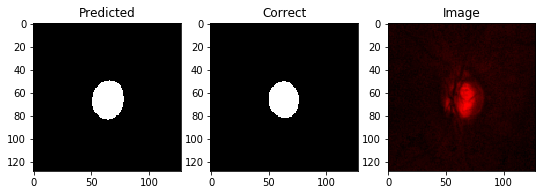

IOU: 0.8563829660415649
Dice: 0.9226361031518625
image #1


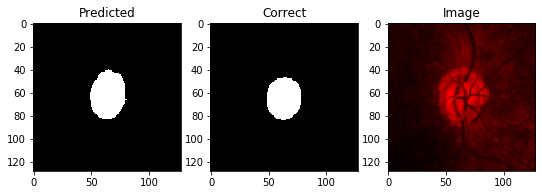

IOU: 0.8139097690582275
Dice: 0.8974093264248705
image #2


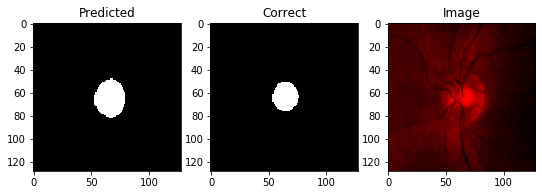

IOU: 0.6455331444740295
Dice: 0.7845884413309983
image #3


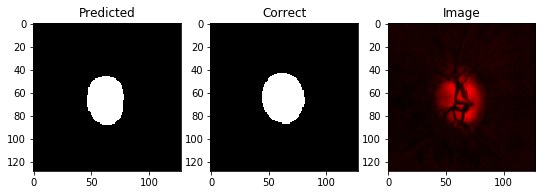

IOU: 0.8270270228385925
Dice: 0.9053254437869822
image #4


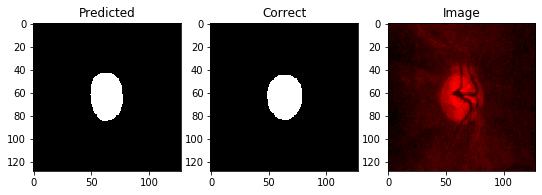

IOU: 0.8703703880310059
Dice: 0.9306930693069307
image #5


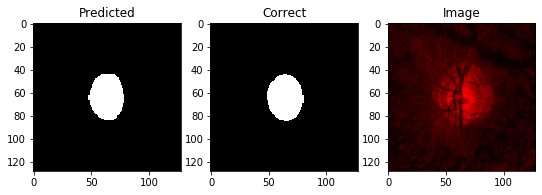

IOU: 0.9003868699073792
Dice: 0.9475826972010178
image #6


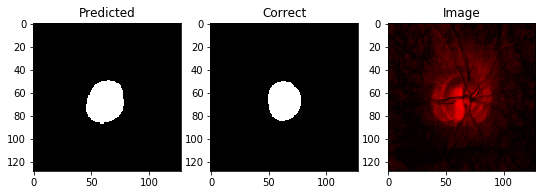

IOU: 0.8130165338516235
Dice: 0.8968660968660969
image #7


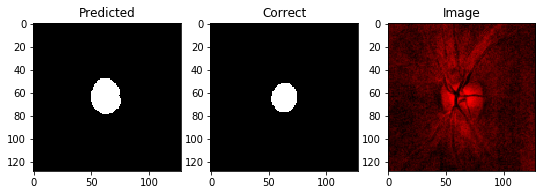

IOU: 0.699999988079071
Dice: 0.8235294117647058
image #8


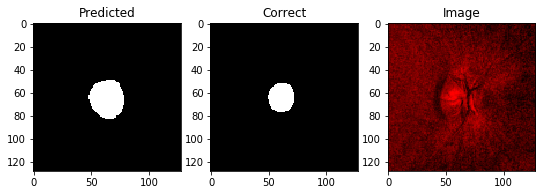

IOU: 0.5714285969734192
Dice: 0.7272727272727273
image #9


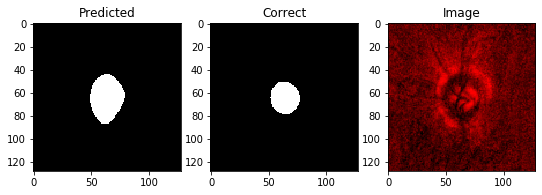

IOU: 0.5853403210639954
Dice: 0.7384412153236459
image #10


TypeError: list indices must be integers or slices, not tuple

In [26]:
pred_iou, pred_dice = [], []
pred_cup = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = red_channel_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_cup.append(pred)
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [27]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.7583395
0.8574344532429837


### Training and Test disc

In [28]:
X_valid, Z_valid = next(data_generator(red_channel_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [29]:
history = model.fit_generator(data_generator(red_channel_train, disc_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Z_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_red.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_red.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500
99/99 [==============================] - 42s 428ms/step - loss: 0.1417 - mean_IOU_gpu: 0.7456 - dice_metric: 0.8462 - val_loss: 0.1008 - val_mean_IOU_gpu: 0.7956 - val_dice_metric: 0.8823
Epoch 2/500
99/99 [==============================] - 40s 406ms/step - loss: 0.1005 - mean_IOU_gpu: 0.7845 - dice_metric: 0.8768 - val_loss: 0.0992 - val_mean_IOU_gpu: 0.7990 - val_dice_metric: 0.8846
Epoch 3/500
99/99 [==============================] - 47s 474ms/step - loss: 0.0887 - mean_IOU_gpu: 0.8062 - dice_metric: 0.8903 - val_loss: 0.0897 - val_mean_IOU_gpu: 0.8122 - val_dice_metric: 0.8936
Epoch 4/500
99/99 [==============================] - 52s 527ms/step - loss: 0.0846 - mean_IOU_gpu: 0.8127 - dice_metric: 0.8947 - val_loss: 0.0927 - val_mean_IOU_gpu: 0.8084 - val_dice_metric: 0.8910
Epoch 5/500
99/99 [==============================] - 47s 470ms/step - loss: 0.0758 - mean_IOU_gpu: 0.8294 - dice_metric: 0.9049 - val_loss: 0.0962 - val_mean_IOU_gpu: 0.8037 - val_dice_metric: 0.8879


Epoch 42/500
99/99 [==============================] - 44s 441ms/step - loss: 0.0735 - mean_IOU_gpu: 0.8349 - dice_metric: 0.9087 - val_loss: 0.0846 - val_mean_IOU_gpu: 0.8174 - val_dice_metric: 0.8971
Epoch 43/500
99/99 [==============================] - 45s 450ms/step - loss: 0.0674 - mean_IOU_gpu: 0.8464 - dice_metric: 0.9157 - val_loss: 0.0839 - val_mean_IOU_gpu: 0.8182 - val_dice_metric: 0.8978
Epoch 44/500
99/99 [==============================] - 43s 439ms/step - loss: 0.0654 - mean_IOU_gpu: 0.8506 - dice_metric: 0.9182 - val_loss: 0.0836 - val_mean_IOU_gpu: 0.8188 - val_dice_metric: 0.8980
Epoch 45/500
99/99 [==============================] - 43s 433ms/step - loss: 0.0651 - mean_IOU_gpu: 0.8514 - dice_metric: 0.9186 - val_loss: 0.0894 - val_mean_IOU_gpu: 0.8090 - val_dice_metric: 0.8920
Epoch 46/500
99/99 [==============================] - 42s 420ms/step - loss: 0.0681 - mean_IOU_gpu: 0.8432 - dice_metric: 0.9139 - val_loss: 0.0862 - val_mean_IOU_gpu: 0.8155 - val_dice_metric: 0.

KeyboardInterrupt: 

In [ ]:
pred_iou, pred_dice = [], []
pred_disc = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = red_channel_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_z = Z_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_disc.append(pred)
    corr = th_to_tf_encoding(batch_z)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Cálculo do CDR

In [ ]:
def ellipseFitting(img):
    contours, hierarchy = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    ellipse = np.zeros(img.shape)
    diametro = []
    for ind, cont in enumerate(contours):
        (x,y),(MA,ma),angle = cv2.fitEllipse(cont)
        diametro.append((MA, ma))
        #feed the parsed parameters into cv2.ellipse
        cv2.ellipse(ellipse,(int(x),int(y)),(int(MA/2), int(ma/2)),angle,0,360,(255,255,255),0)
    return ellipse, diametro

In [ ]:
cdrs = []
for i, img_no in enumerate(test_idx):
    cup = pred_cup[i]
    disc = pred_disc[i]
        
    c = cv2.Canny(cup.astype(np.uint8), 1,1)
    d = cv2.Canny(disc.astype(np.uint8), 1,1)
    
    el_c, diam_c = ellipseFitting(c)
    el_d, diam_d = ellipseFitting(d)
        
    if len(diam_d) > 0 and len(diam_c) > 0:
        cdr = diam_c[0][1]/diam_d[0][1]
        cdrs.append(cdr)
        print('image #{} - cdr = {}'.format(img_no, cdr))
